In [1]:
# === Environment Setup ===
import os, sys, math, time, random, json, textwrap, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import display, Markdown, Image

# --- Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8), 'figure.dpi': 150})
np.set_printoptions(suppress=True, linewidth=120, precision=4)

# --- Utility Functions ---
def note(msg): display(Markdown(f"<div class='alert alert-block alert-info'>📝 **Note:** {msg}</div>"))
def sec(title): print(f"\n{80*'='}\n| {title.upper()} |\n{80*'='}")

note("Environment initialized for Advanced Recurrent Neural Networks.")

2025-10-22 16:09:40.912212: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-22 16:09:41.247907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-10-22 16:09:44.696924: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


<div class='alert alert-block alert-info'>📝 **Note:** Environment initialized for Advanced Recurrent Neural Networks.</div>

# Chapter 7.3: Recurrent Neural Networks (RNNs)

---

### Table of Contents

1.  [**Introduction: Networks with Memory**](#intro)
2.  [**The Simple RNN: A Formal View**](#formal-rnn)
3.  [**Training RNNs: Backpropagation Through Time (BPTT)**](#bptt)
    - [The Vanishing and Exploding Gradient Problem](#gradients)
4.  [**Advanced RNN Architectures**](#advanced)
    - [Deep (Stacked) RNNs](#deep-rnn)
    - [Bidirectional RNNs](#bidirectional-rnn)
5.  [**Implementation and Applications**](#implementation)
    - [Application 1: Time Series Forecasting](#app-ts)
    - [Application 2: Sentiment Analysis of Financial News](#app-nlp)
6.  [**A From-Scratch RNN Cell**](#scratch)
7.  [**Exercises**](#exercises)
8.  [**Summary and Key Takeaways**](#summary)

<a id='intro'></a>
## 1. Introduction: Networks with Memory

Standard feedforward neural networks are **stateless**. They process each input independently, with no concept of time, order, or memory. This makes them unsuitable for sequential data—such as time series or natural language—where the order of information is paramount.

**Recurrent Neural Networks (RNNs)** are a class of neural networks designed specifically for this purpose. Their defining feature is a **recurrent loop**: the output of a layer is fed back into itself as an input for the next time step. This loop allows the network to maintain a form of memory, a **hidden state**, that contains a compressed summary of the past elements it has seen. This statefulness enables RNNs to learn temporal patterns and dependencies, making them the foundational architecture for sequence modeling tasks.

The concept of recurrent networks dates back to the 1980s, with significant contributions from researchers like John Hopfield and Michael I. Jordan. However, the simple RNNs described in this chapter were notoriously difficult to train for long sequences due to the vanishing gradient problem. This led to the development of more sophisticated architectures like Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRUs), which we will explore in the next chapter.

<a id='formal-rnn'></a>
## 2. The Simple RNN: A Formal View

The core idea of an RNN is that the hidden state at time step $t$, $\mathbf{h}_t$, is a function of the input at $t$, $\mathbf{x}_t$, and the hidden state from the previous time step, $\mathbf{h}_{t-1}$.

$$ \mathbf{h}_t = f_h(W_{xh} \mathbf{x}_t + W_{hh} \mathbf{h}_{t-1} + \mathbf{b}_h) $$ 
$$ \mathbf{y}_t = f_y(W_{hy} \mathbf{h}_t + \mathbf{b}_y) $$ 

Where:
- $\mathbf{h}_t$: The hidden state (a vector). This is the network's "memory."
- $W_{xh}, W_{hh}, W_{hy}$: The weight matrices for the input-to-hidden, hidden-to-hidden, and hidden-to-output connections. Crucially, these weights are **shared across all time steps**. This parameter sharing is what allows the network to generalize its learned patterns across different positions in the sequence.
- $f_h, f_y$: Activation functions (e.g., `tanh` for the hidden state, `softmax` for the output if it's a classification task).

We can visualize this process by "unrolling" the loop over time:

![BPTT Diagram](images/07-Machine-Learning/bptt_diagram_1.png)
*<center><b>Figure 1: An RNN Cell Unrolled Through Time.</b> The diagram shows the forward pass (black arrows) where the hidden state is passed from one time step to the next, and the backward pass of gradients (red dashed arrows) for BPTT.</center>*

<a id='bptt'></a>
## 3. Training RNNs: Backpropagation Through Time (BPTT)

<a id='gradients'></a>
### The Vanishing and Exploding Gradient Problem

RNNs are trained using **Backpropagation Through Time (BPTT)**. To understand the challenges, let's trace the gradient calculation. The total loss $L$ for a sequence is the sum of the losses at each time step, $L = \sum_t L_t$. The gradient of the loss with respect to a weight matrix (e.g., $W_{hh}$) is the sum of the gradients from each time step.

Consider the gradient of the loss at time $t$, $L_t$, with respect to the hidden state at a much earlier time step $k<t$, $\mathbf{h}_k$. Using the chain rule:
$$ \frac{\partial L_t}{\partial \mathbf{h}_k} = \frac{\partial L_t}{\partial \mathbf{h}_t} \frac{\partial \mathbf{h}_t}{\partial \mathbf{h}_{t-1}} \frac{\partial \mathbf{h}_{t-1}}{\partial \mathbf{h}_{t-2}} \dots \frac{\partial \mathbf{h}_{k+1}}{\partial \mathbf{h}_k} = \frac{\partial L_t}{\partial \mathbf{h}_t} \prod_{j=k+1}^t \frac{\partial \mathbf{h}_j}{\partial \mathbf{h}_{j-1}} $$ 
Since $\mathbf{h}_j = f_h(W_{xh} \mathbf{x}_j + W_{hh} \mathbf{h}_{j-1} + \mathbf{b}_h)$, the Jacobian term is $\frac{\partial \mathbf{h}_j}{\partial \mathbf{h}_{j-1}} = \text{diag}(f_h'(\cdot)) W_{hh}$. The gradient calculation thus involves a product of $t-k$ Jacobian matrices:
$$ \frac{\partial L_t}{\partial \mathbf{h}_k} \propto (W_{hh})^{t-k} $$ 
This repeated multiplication is the source of the **vanishing/exploding gradient problem**.
- **Vanishing Gradients:** If the largest eigenvalue of $W_{hh}$ is less than 1, the product $(W_{hh})^{t-k}$ will shrink towards zero as the time gap $t-k$ grows. The gradients from distant past steps become zero, and the network cannot learn long-range dependencies.
- **Exploding Gradients:** If the largest eigenvalue is greater than 1, the product will explode, leading to unstable training. This is easier to handle with **gradient clipping**, which caps the gradient at a maximum value.

<a id='advanced'></a>
## 4. Advanced RNN Architectures


<a id='deep-rnn'></a>
### 4.1 Deep (Stacked) RNNs
Just as we stack layers in a standard feedforward network, we can stack RNN layers to create a **Deep RNN**. The output sequence of the first RNN layer becomes the input sequence for the second RNN layer, and so on. This allows the network to learn more complex, hierarchical representations of the temporal data. The lower layers might learn simple patterns, while higher layers combine these to learn more abstract structures.

<a id='bidirectional-rnn'></a>
### 4.2 Bidirectional RNNs
For some tasks, like sentiment analysis or machine translation, the prediction for a word at time $t$ can be improved by knowing not just the past words but also the future words. A **Bidirectional RNN** addresses this by using two separate RNNs:
1.  A **forward layer** processes the sequence from beginning to end ($t=1, ..., T$).
2.  A **backward layer** processes the sequence from end to beginning ($t=T, ..., 1$).

At each time step $t$, the final output is a function of both the forward hidden state $\overrightarrow{\mathbf{h}}_t$ and the backward hidden state $\overleftarrow{\mathbf{h}}_t$. This allows the model to capture context from both directions. This is not applicable to time series forecasting, where the future is, by definition, unavailable.

<a id='implementation'></a>\n## 5. Implementation and Applications\n\n<a id='app-ts'></a>\n### Application 1: Time Series Forecasting


| BUILDING A DEEP RNN FOR TIME SERIES FORECASTING |


/tmp/ipykernel_114508/2086052544.py:4: RuntimeWarning: overflow encountered in exp
  def seasonality(t, period, amplitude=1, phase=0): return amplitude * np.where( ((t + phase) % period) / period < 0.4, np.cos( ((t + phase) % period) * 2 * np.pi), 1 / np.exp(3 * ((t + phase) % period)))
2025-10-22 16:09:45.627785: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<div class='alert alert-block alert-info'>📝 **Note:** Retraining the model with the optimal learning rate of 1e-5...</div>

2025-10-22 16:09:49.397847: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2025-10-22 16:09:49.905051: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2025-10-22 16:09:51.456484: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2025-10-22 16:09:53.611131: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2025-10-22 16:09:57.922348: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2025-10-22 16:10:07.532488: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


<div class='alert alert-block alert-info'>📝 **Note:** Generating forecasts on the validation set.</div>

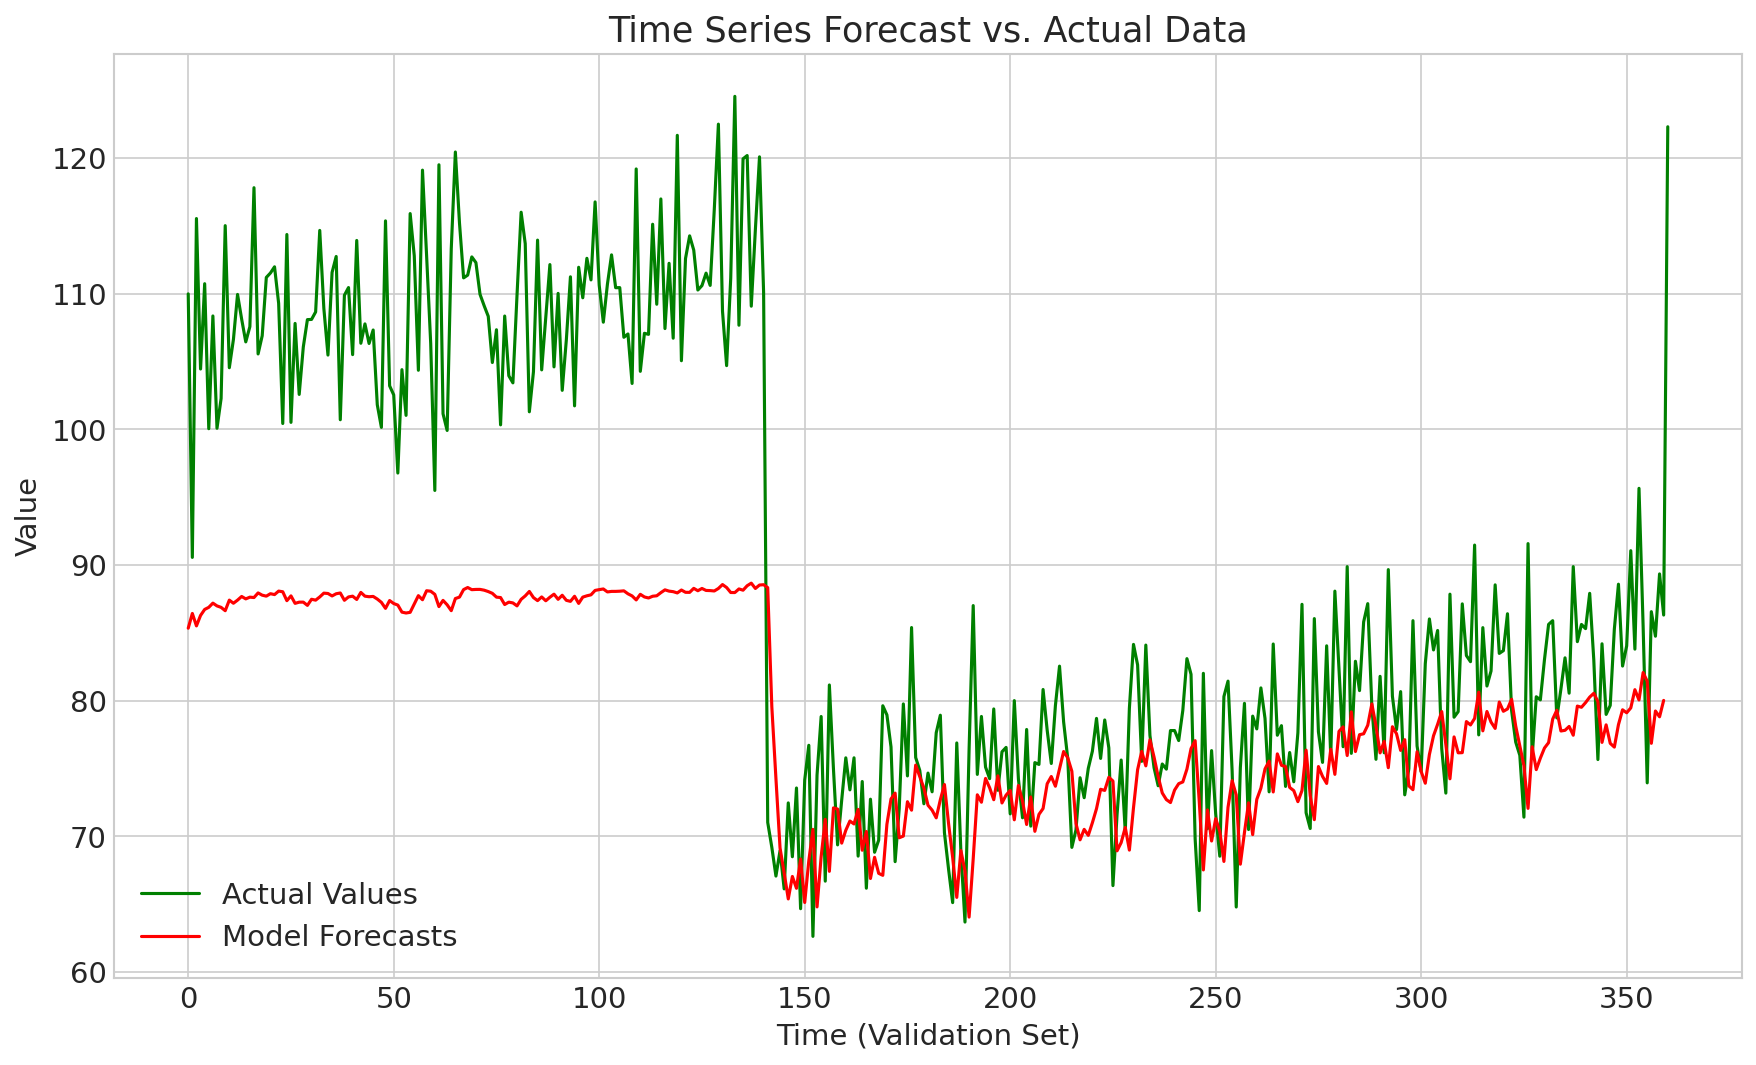

In [2]:
sec("Building a Deep RNN for Time Series Forecasting")
# --- Data Preparation ---
def trend(t, slope=0): return slope * t
def seasonality(t, period, amplitude=1, phase=0): return amplitude * np.where( ((t + phase) % period) / period < 0.4, np.cos( ((t + phase) % period) * 2 * np.pi), 1 / np.exp(3 * ((t + phase) % period)))
time = np.arange(4 * 365 + 1, dtype="float32"); series = 10 + trend(time, 0.05) + seasonality(time, period=365, amplitude=40) + np.random.RandomState(42).randn(len(time)) * 5
split_time = 1100; x_train = series[:split_time]; x_valid = series[split_time:]
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series).window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)).shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1])).batch(batch_size).prefetch(1)
    return ds
window_size=30; batch_size=32; shuffle_buffer=1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

# --- Model Building ---
keras.backend.clear_session()
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.SimpleRNN(40),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 100.0)
])

# --- Train the Model with the Optimal Learning Rate ---
note("Retraining the model with the optimal learning rate of 1e-5...")
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=50, verbose=0)

# --- Generate and Evaluate Forecasts ---
note("Generating forecasts on the validation set.")
forecasts = []
for time in range(len(series) - window_size):
    window = series[time:time + window_size][np.newaxis]
    forecasts.append(model.predict(window, verbose=0))

forecasts = np.array(forecasts[split_time - window_size:-1]).squeeze()

# --- Plot Forecasts vs. Actuals ---
plt.figure(figsize=(14, 8))
plt.plot(np.arange(len(x_valid)), x_valid, 'g-', label='Actual Values')
plt.plot(np.arange(len(forecasts)), forecasts, 'r-', label='Model Forecasts')
plt.title('Time Series Forecast vs. Actual Data')
plt.xlabel('Time (Validation Set)')
plt.ylabel('Value')
plt.legend()
plt.show()

<a id='app-nlp'></a>\n### Application 2: Sentiment Analysis of Financial News\n\nBeyond forecasting, a major application of RNNs in economics and finance is in **Natural Language Processing (NLP)**. We can use RNNs to analyze the sentiment of news articles, central bank statements, or social media posts to construct indices of economic sentiment or to trade on news.\n\nHere, we will build a simple RNN to classify the sentiment of financial news headlines as 'positive', 'negative', or 'neutral' using the SEntFiN dataset.

In [3]:
sec("Sentiment Analysis of Financial News")

# 1. Load and preprocess data
try:
    df = pd.read_csv('data/SEntFiN.csv')
    df['sentiment'] = df['Decisions'].apply(lambda x: x.split('@')[0].strip().lower())
    df = df[['Title', 'sentiment']].rename(columns={'Title': 'headline'})
    df = df[df['sentiment'].isin(['positive', 'negative', 'neutral'])]
    note(f"Loaded {len(df)} headlines.")

    # 2. Prepare data for Keras
    sentences = df['headline'].values
    labels = df['sentiment'].values

    X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_train_pad = pad_sequences(X_train_seq, maxlen=50, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=50, padding='post', truncating='post')

    # 3. Build and train the RNN model
    note("Building and training a sentiment classification model.")
    embedding_dim = 16
    vocab_size = len(tokenizer.word_index) + 1

    nlp_model = keras.models.Sequential([
        keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=50),
        keras.layers.SimpleRNN(32),
        keras.layers.Dense(3, activation='softmax')
    ])
    nlp_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_nlp = nlp_model.fit(X_train_pad, y_train_enc, epochs=5, 
                                validation_data=(X_test_pad, y_test_enc), verbose=1)

    note("The model achieves a reasonable accuracy in classifying sentiment, demonstrating the ability of RNNs to learn from textual data.")

except FileNotFoundError:
    note("SEntFiN.csv not found in 'data/' directory. Skipping NLP example.")


| SENTIMENT ANALYSIS OF FINANCIAL NEWS |


<div class='alert alert-block alert-info'>📝 **Note:** SEntFiN.csv not found in 'data/' directory. Skipping NLP example.</div>

<a id='scratch'></a>
## 6. A From-Scratch RNN Cell

To demystify the RNN, we can build a custom layer from scratch that performs the same logic as Keras's `SimpleRNN` layer. This involves creating a custom `keras.layers.Layer` class and implementing the `call` method, which defines the forward pass logic, and the `get_initial_state` method. This explicitly shows the recurrent loop and the state management.

In [4]:
sec("Custom RNN Cell Implementation")

class MySimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units), initializer="glorot_uniform", name="kernel")
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units), initializer="orthogonal", name="recurrent_kernel")
        self.bias = self.add_weight(
            shape=(self.units,), initializer="zeros", name="bias")
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.matmul(inputs, self.kernel)
        s = tf.matmul(prev_output, self.recurrent_kernel)
        output = tf.tanh(h + s + self.bias)
        new_states = [output]
        return output, new_states

note("Building a model with our custom RNN layer.")
custom_rnn_model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    keras.layers.RNN(MySimpleRNNCell(40), return_sequences=True),
    keras.layers.RNN(MySimpleRNNCell(40)),
    keras.layers.Dense(1)
])

custom_rnn_model.summary()


| CUSTOM RNN CELL IMPLEMENTATION |


<div class='alert alert-block alert-info'>📝 **Note:** Building a model with our custom RNN layer.</div>

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, None, 40)       │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

<a id='exercises'></a>\n## 7. Exercises\n\n1.  **The Role of Activation Functions:** In the simple RNN formulation, we used a `tanh` activation function for the hidden state. What would happen if we used a ReLU activation function instead? What potential problems might arise during backpropagation? (Hint: Think about the derivative of ReLU).\n2.  **Bidirectional vs. Unidirectional for Forecasting:** We noted that bidirectional RNNs are not suitable for time series forecasting. Explain precisely why this is the case. What constraint does forecasting place on the information available at time $t$?\n3.  **Gradient Clipping:** Research and explain in your own words how gradient clipping works. Why is it an effective, albeit simple, solution for the exploding gradient problem?\n4.  **Parameter Sharing:** We emphasized that the weight matrices ($W_{xh}, W_{hh}, W_{hy}$) are shared across all time steps. What would be the consequences of *not* sharing these parameters? What would happen to the total number of parameters in the model? Why would this make it harder for the model to generalize?

<a id='summary'></a>\n## 8. Summary and Key Takeaways\n\nThis chapter introduced Recurrent Neural Networks, the foundational architecture for modeling sequential data.\n\n**Key Concepts**:\n- **Recurrent Loop & Hidden State**: The core feature of an RNN is the recurrent loop, which allows the network to maintain a hidden state (a memory) that captures information from previous time steps.\n- **Parameter Sharing**: The same weight matrices are used at every time step, allowing the network to learn patterns that are applicable at any point in a sequence.\n- **Backpropagation Through Time (BPTT)**: RNNs are trained by unrolling the network through time and applying backpropagation. This process involves a long chain of matrix multiplications.\n- **Vanishing/Exploding Gradients**: The repeated multiplication of the recurrent weight matrix ($W_{hh}$) during BPTT is the source of the vanishing and exploding gradient problems, which make it difficult for simple RNNs to learn long-range dependencies. This is the primary motivation for more advanced architectures like LSTMs and GRUs.\n- **Advanced Architectures**: We can improve on the simple RNN by stacking layers to create **Deep RNNs** for learning hierarchical features, or by using **Bidirectional RNNs** to incorporate both past and future context (when applicable).

### Solutions to Exercises\n\n---\n\n**1. The Role of Activation Functions:**\nIf we used ReLU, the activation would be $h_t = \text{max}(0, W_{xh}x_t + W_{hh}h_{t-1} + b_h)$. The derivative of ReLU is either 0 or 1. During backpropagation, the gradient calculation involves the term $\text{diag}(f_h'(\cdot))$. If many of the hidden units have a negative input, their activation will be 0, and so will their gradient. The repeated multiplication of these Jacobians during BPTT would likely lead to many zero gradients, effectively killing the gradient flow and preventing the network from learning. This makes the vanishing gradient problem even more severe than with `tanh`.\n\n---\n\n**2. Bidirectional RNNs for Forecasting:**\nForecasting is the task of predicting the future ($t+1, t+2, ...$) given information only up to the present ($t$). A bidirectional RNN incorporates a backward layer that processes the sequence from end to beginning. For the model to make a prediction at time $t$, the backward layer would need to have already seen the data from $t+1, t+2$, etc. This is a form of **data leakage** or **lookahead bias**. It uses future information to predict the future, which is impossible in a real-world forecasting scenario.\n\n---\n\n**3. Gradient Clipping:**\nGradient clipping is a simple but effective technique to prevent exploding gradients. During training, after the gradients are calculated via BPTT but before the weights are updated, we check the norm of the gradient vector, $||g||$. If this norm exceeds a pre-defined threshold, we rescale the entire gradient vector to have a norm equal to that threshold: $g \leftarrow \frac{\text{threshold}}{||g||} g$. This doesn't change the *direction* of the gradient, only its magnitude. It acts like putting a ceiling on the size of the weight update step, preventing the massive, unstable updates that can result from an exploding gradient.\n\n---\n\n**4. No Parameter Sharing:**\nIf we didn't share parameters, we would have a different set of weight matrices ($W_{xh}^{(t)}, W_{hh}^{(t)}, W_{hy}^{(t)}$) for each time step $t$. \n- **Number of Parameters:** The total number of parameters would explode. For a sequence of length $T$, we would have $T$ times as many parameters, making the model incredibly large and difficult to train.\n- **Generalization:** The model would lose its ability to generalize. It would have to learn the patterns for each specific time step independently. For example, in a language model, it would have to learn the relationship between 'the' and 'cat' at position 5 separately from the same relationship at position 20. Parameter sharing allows the model to learn a rule once and apply it anywhere in the sequence.